In [1]:
# Import Library
import os
import cv2
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, ReLU
from tensorflow.keras import Input, Model
from tensorflow.keras.regularizers import l2 
import matplotlib.pyplot as plt  
from skimage import io  
import keras
from skimage.metrics import structural_similarity as ssim

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


## DATASET CREATION

In [2]:
# Hazy Image From Original Image for Dataset 
# NOTE : DO NOT RUN THIS CODE ONCE THE IMAGES ARE GENERATED 
# def generate_foggy_image(image_path, beta = 0.023, A = 60, sigma = 0.02):
#     # Load the original clear image
#     clear_image = cv2.imread(image_path)

#     # Define atmospheric parameters
#     transmission_map = np.zeros((clear_image.shape[0], clear_image.shape[1]), dtype=np.float32)

#     # Compute the transmission map using Koschmieder model with added Gaussian noise
#     for i in range(clear_image.shape[0]):
#         for j in range(clear_image.shape[1]):
#             noise = np.random.normal(0, sigma)
#             transmission_map[i, j] = np.exp(-beta * A) + noise

#     # Clip the transmission map to the range [0, 1]
#     transmission_map = np.clip(transmission_map, 0, 1)

#     # Apply the atmospheric scattering model to generate foggy image
#     foggy_image = np.zeros_like(clear_image)
#     for channel in range(3):
#         foggy_image[:, :, channel] = clear_image[:, :, channel] * transmission_map + (1 - transmission_map) * 210

#     return foggy_image

# # Set the paths for the input and output folders
# input_folder = "C:/Users/lokes/Downloads/CVIP project Dehazing/CVIP Dataset Lokesh/clear_images/"
# output_folder = "C:/Users/lokes/Downloads/CVIP project Dehazing/CVIP Dataset Lokesh/Hazy_images/"

# # Create the output folder if it doesn't exist
# if not os.path.exists(output_folder):
#     os.makedirs(output_folder)

# # Loop over all files in the input folder
# for filename in os.listdir(input_folder):
#     # Check if the file is an image file
#     if filename.endswith(".jpg") or filename.endswith(".png"):
#         # Generate the foggy image
#         clear_image_path = os.path.join(input_folder, filename)
#         foggy_image = generate_foggy_image(clear_image_path)

#         # Save the foggy image to the output folder
#         foggy_image_path = os.path.join(output_folder, filename)
#         cv2.imwrite(foggy_image_path, foggy_image)

#         print(f"Saved foggy image: {foggy_image_path}")

## DEHAZING PROJECT 

In [3]:
# Dataset
hazy_dir = "/kaggle/input/cvip-dehazing-project/CVIP Dataset Lokesh/Hazy_images"
clear_dir = "/kaggle/input/cvip-dehazing-project/CVIP Dataset Lokesh/clear_images"

In [4]:
# Define AOD_Net model 
def haze_net(input_shape):
    
#     K_INITIALIZER = tf.initializers.RandomNormal(stddev = 0.02)
    K_REGULARISATION = l2(weight_decay)
    ACTIVATION = "relu"
    BIAS = True
    PADDING = "SAME"
    X = Input(shape = input_shape)
    
    conv1 = Conv2D(3, 1, padding = PADDING, activation = ACTIVATION, use_bias = BIAS, 
                   kernel_initializer = tf.initializers.RandomNormal(stddev = 0.02),
                   kernel_regularizer = K_REGULARISATION )(X)
    
    conv2 = Conv2D(3, 3, padding = PADDING, activation = ACTIVATION, use_bias = BIAS, 
                   kernel_initializer = tf.initializers.RandomNormal(stddev = 0.02),
                   kernel_regularizer = K_REGULARISATION )(conv1)
    concat1 = tf.concat([conv1, conv2], axis = -1)
  
    conv3 = Conv2D(3, 5, padding = PADDING, activation = ACTIVATION, use_bias = BIAS, 
                   kernel_initializer = tf.initializers.RandomNormal(stddev = 0.02),
                   kernel_regularizer = K_REGULARISATION )(concat1)
    concat2 = tf.concat([conv2, conv3], axis = -1)
  
    conv4 = Conv2D(3, 7, padding = PADDING, activation = ACTIVATION, use_bias = BIAS, 
                   kernel_initializer = tf.initializers.RandomNormal(stddev = 0.02),
                   kernel_regularizer = K_REGULARISATION )(concat2)
    concat3 = tf.concat([conv1, conv2, conv3, conv4], axis = -1)
  
    conv5 = Conv2D(3, 3, padding = PADDING, activation = ACTIVATION, use_bias = BIAS, 
                   kernel_initializer = tf.initializers.RandomNormal(stddev = 0.02),
                   kernel_regularizer = K_REGULARISATION )(concat3)
    K = conv5
  
    output = ReLU(max_value = 1.0)(tf.math.multiply(K, X) - K + 1.0)
  
    model = Model(inputs = X, outputs = output)
  
    return model

In [5]:
learning_rate = 1e-4
weight_decay = 1e-4

# Function to load and preprocess images
def load_images(directory, size):
    images = []
    for filename in os.listdir(directory):
        img = cv2.imread(os.path.join(directory, filename))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, size) / 255.0 # resize and normalize pixel values to [0,1]
        images.append(img)
    return np.array(images)

# Load hazy and clear images
size = (512, 512) # fixed size for resizing images
hazy_images = load_images(hazy_dir, size)
clear_images = load_images(clear_dir, size)
 
input_shape = (512, 512, 3)
model = haze_net(input_shape)


In [6]:
# Compile the model
model.compile(optimizer = 'adam', loss = 'mse')

# Train the model
history = model.fit(hazy_images, clear_images, batch_size = 64, epochs = 10, validation_split = 0.2)

# Save the model
model.save('AOD_Net_reg.h5')

Epoch 1/10
11/11 [==============================] - 483s 44s/step - loss: 0.3935 - val_loss: 0.3940
Epoch 2/10
11/11 [==============================] - 481s 44s/step - loss: 0.3801 - val_loss: 0.3715
Epoch 3/10
11/11 [==============================] - 479s 44s/step - loss: 0.3432 - val_loss: 0.3030
Epoch 4/10
11/11 [==============================] - 478s 43s/step - loss: 0.2244 - val_loss: 0.1015
Epoch 5/10
11/11 [==============================] - 477s 43s/step - loss: 0.0551 - val_loss: 0.0593
Epoch 6/10
11/11 [==============================] - 477s 43s/step - loss: 0.0383 - val_loss: 0.0360
Epoch 7/10
11/11 [==============================] - 475s 43s/step - loss: 0.0341 - val_loss: 0.0292
Epoch 8/10
11/11 [==============================] - 475s 43s/step - loss: 0.0304 - val_loss: 0.0293
Epoch 9/10
11/11 [==============================] - 473s 43s/step - loss: 0.0294 - val_loss: 0.0294
Epoch 10/10
11/11 [==============================] - 472s 43s/step - loss: 0.0292 - val_loss: 0.0288

In [7]:
print(history.history)

{'loss': [0.39352908730506897, 0.3801100254058838, 0.3431923985481262, 0.22444970905780792, 0.05513514205813408, 0.03828040882945061, 0.03410373255610466, 0.030441971495747566, 0.02943200245499611, 0.029192470014095306], 'val_loss': [0.3939673602581024, 0.3714703619480133, 0.30302518606185913, 0.10152312368154526, 0.0593019537627697, 0.035996705293655396, 0.02917085587978363, 0.02925151214003563, 0.029394259676337242, 0.028821906074881554]}


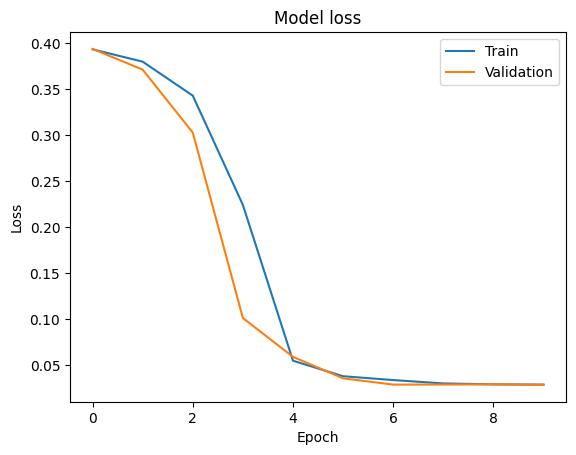

In [8]:
# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

## PLOTS

In [9]:
test_hazy_dir = '/kaggle/input/test-images/Test Images/Test_hazy'
test_clear_dir = '/kaggle/input/test-images/Test Images/Test_clear'
size = (512,512)
test_hazy_images = load_images(test_hazy_dir, size)
test_clear_images = load_images(test_clear_dir, size)

def psnr(y_true, y_pred):
    max_pixel = 1.0
    mse = tf.reduce_mean(tf.square(y_true - y_pred))
    psnr = 20 * tf.math.log(max_pixel / tf.math.sqrt(mse)) / tf.math.log(10.0)
    return psnr.numpy()
 
# Load the trained model
model = keras.models.load_model('/kaggle/working/AOD_Net_reg.h5')

# Evaluate the model on the test set
loss = model.evaluate(test_hazy_images, test_clear_images)
psnr = tf.image.psnr(test_clear_images, model.predict(test_hazy_images), max_val=1.0)


print('Test set loss: ', loss)
print('Test set PSNR: ', psnr.numpy()) 

1/1 [==============================] - 5s 5s/step
Test set loss:  0.029078200459480286
Test set PSNR:  [15.386379 16.93341  17.20929  17.681513 14.299724 15.922567 15.138871
 15.919651 16.797615 14.366471 14.225435 14.640555 16.920668 17.10158
 15.761845 17.096346 15.057196 17.325346 14.106465 15.816274 14.742849
 14.635643 15.83915  14.222573 16.530037 15.270049 15.519273 13.781108
 14.574945 14.551592 14.000663]


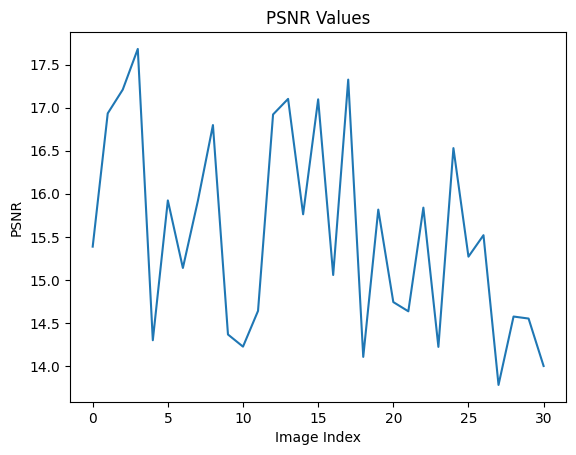

In [10]:
# PSNR Graph
plt.plot(psnr.numpy())
plt.title('PSNR Values')
plt.xlabel('Image Index')
plt.ylabel('PSNR')
plt.show()

1/1 [==============================] - 5s 5s/step


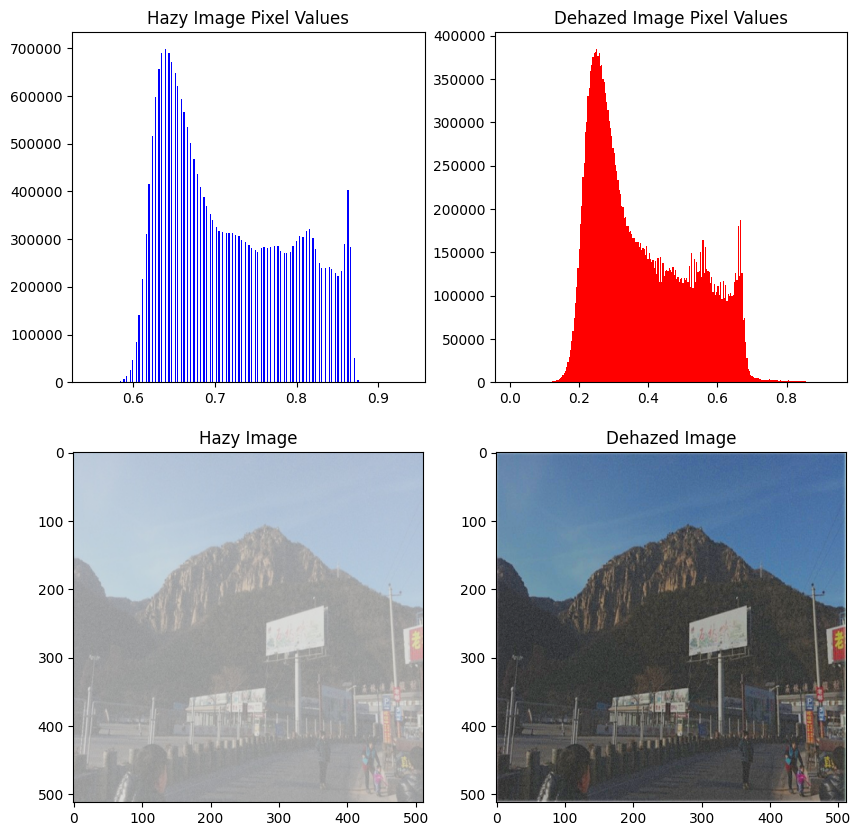

In [11]:
# Make predictions on all test images
test_predictions = model.predict(test_hazy_images)

# Plot histograms of pixel values for the hazy and dehazed images
fig, axs = plt.subplots(2, 2, figsize=(10, 10))
axs[0, 0].hist(test_hazy_images.ravel(), bins=256, color='b')
axs[0, 0].set_title('Hazy Image Pixel Values')
axs[0, 1].hist(test_predictions.ravel(), bins=256, color='r')
axs[0, 1].set_title('Dehazed Image Pixel Values')
axs[1, 0].imshow(cv2.convertScaleAbs(test_hazy_images[0] * 255.0))
axs[1, 0].set_title('Hazy Image')
axs[1, 1].imshow(cv2.convertScaleAbs(test_predictions[0] * 255.0))
axs[1, 1].set_title('Dehazed Image')
plt.show()

1/1 [==============================] - 1s 723ms/step


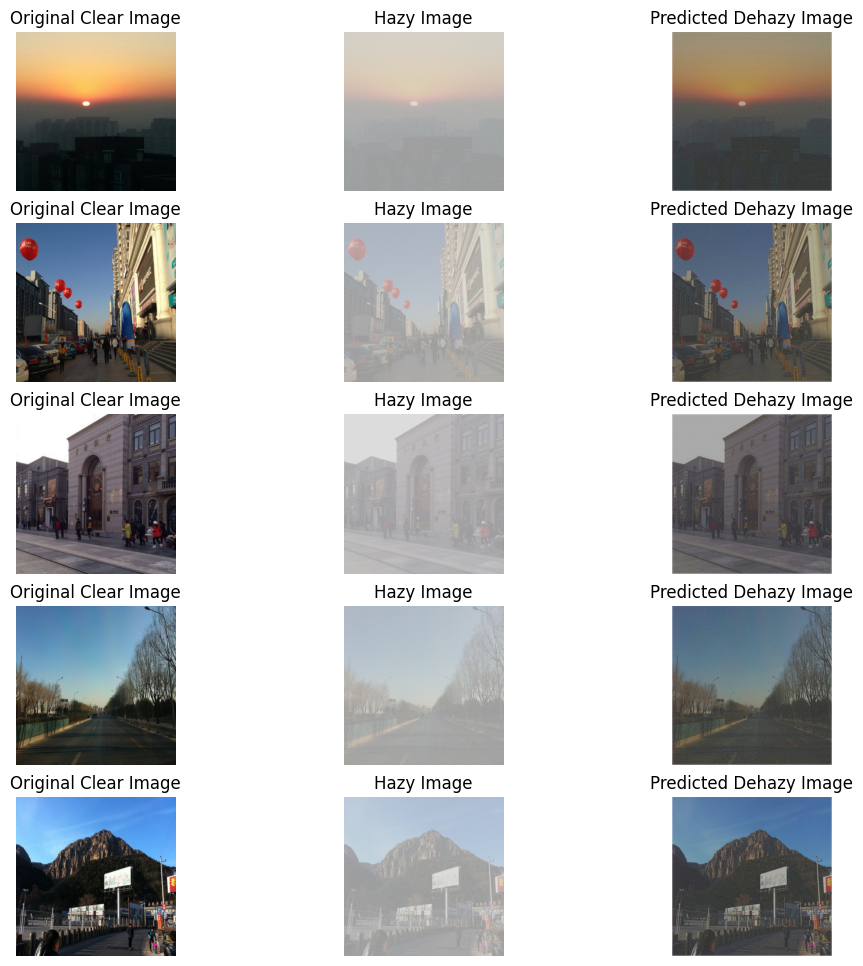

In [12]:
# Select 5 random images from the test set
indices = np.random.choice(len(test_hazy_images), 5, replace=False)
hazy_images = np.array([test_hazy_images[i] for i in indices])
clear_images = np.array([test_clear_images[i] for i in indices])

# Get the predicted dehazy images
predicted_images = model.predict(hazy_images)
predicted_images = np.clip(predicted_images, 0, 1)

# Plot the images
fig, axs = plt.subplots(nrows=5, ncols=3, figsize=(12, 12))
for i in range(5):
    axs[i, 1].imshow(hazy_images[i])
    axs[i, 1].set_title('Hazy Image')
    axs[i, 2].imshow(predicted_images[i])
    axs[i, 2].set_title('Predicted Dehazy Image')
    axs[i, 0].imshow(clear_images[i])
    axs[i, 0].set_title('Original Clear Image')
    for j in range(3):
        axs[i, j].axis('off')
plt.show()

## DEHAZING THE IMAGE BY TAKING INPUT

1/1 [==============================] - 0s 264ms/step


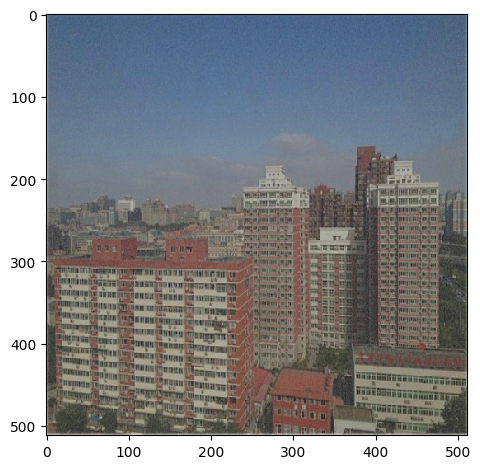

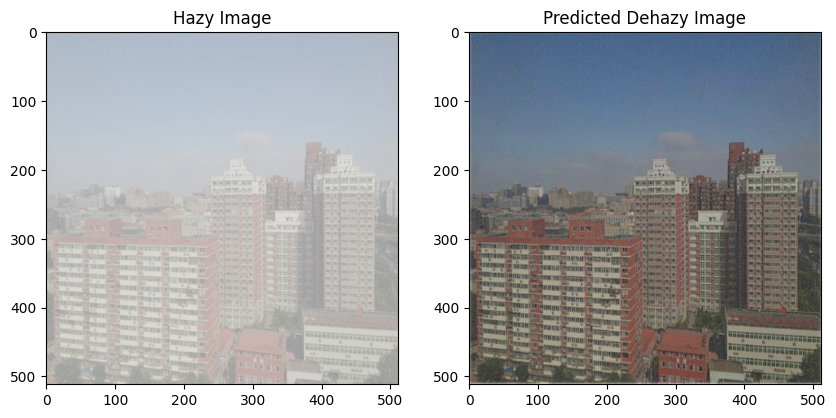

In [13]:
# Load the saved model
model = tf.keras.models.load_model('/kaggle/working/AOD_Net_reg.h5')

# Load the hazy image
img = cv2.imread('/kaggle/input/cvip-dehazing-project/CVIP Dataset Lokesh/Hazy_images/0001.jpg')
size = (512,512)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img = cv2.resize(img, size) / 255.0

# Use the model to dehaze the image
dehazed_img = model.predict(np.expand_dims(img, axis=0))[0] 

# Save the dehazed image
dehazed_img = np.clip(dehazed_img * 255.0, 0, 255).astype(np.uint8)
cv2.imwrite('dehazed_image.jpg', cv2.cvtColor(dehazed_img, cv2.COLOR_RGB2BGR))
io.imshow(dehazed_img)
io.show()

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(10, 10))
axs[1].imshow(dehazed_img)
axs[1].set_title('Predicted Dehazy Image')
axs[0].imshow(img)
axs[0].set_title('Hazy Image')
plt.show()


## References 
1. https://www.tensorflow.org/resources/libraries-extensions
2. https://matplotlib.org/stable/gallery/index.html
3. https://towardsdatascience.com/all-in-one-image-dehazing-aod-paper-explanation-tensorflow-implementation-bb97f6a6f1ef
4. 